In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [3]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);

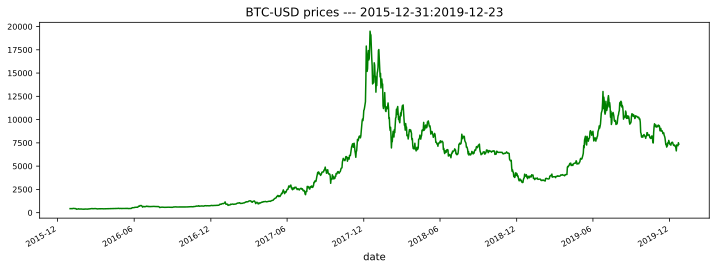

In [4]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-23', 
                  freq='daily', 
                  path='data/BTC.csv')

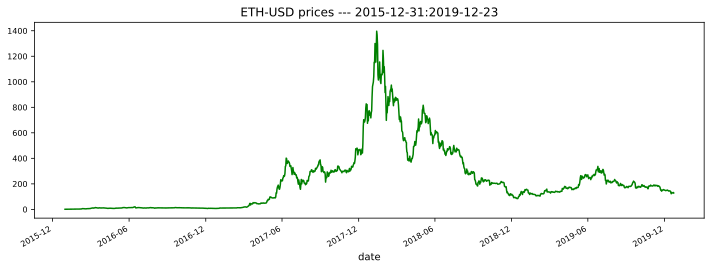

In [5]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-23', 
                  freq='daily', 
                  path='data/ETH.csv')

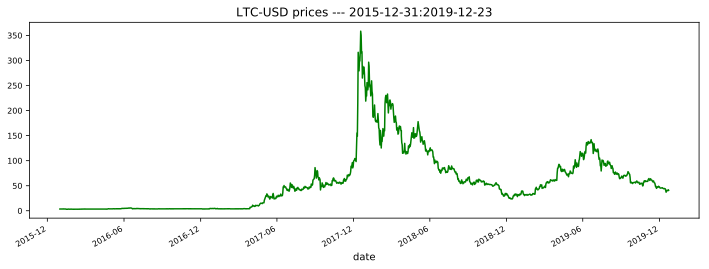

In [6]:
download_csv_data(ticker='LTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-23', 
                  freq='daily', 
                  path='data/LTC.csv')

In [7]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH', 'LTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [8]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                   open        close
date                                
2019-12-19  7202.844238  7202.844238
2019-12-20  7218.816406  7218.816406
2019-12-21  7191.158691  7191.158691
2019-12-22  7511.588867  7511.588867
2019-12-23  7355.628418  7355.628418
                  open       close
date                              
2019-12-19  129.321136  129.321136
2019-12-20  129.066055  129.066055
2019-12-21  128.130951  128.130951
2019-12-22  132.372513  132.372513
2019-12-23  128.614090  128.614090
                 open      close
date                            
2019-12-19  39.920296  39.920296
2019-12-20  40.290157  40.290157
2019-12-21  39.996830  39.996830
2019-12-22  41.965191  41.965191
2019-12-23  40.847473  40.847473


In [9]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 1454 (major_axis) x 2 (minor_axis)
Items axis: BTC to LTC
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-23 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [10]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

,BTC,ETH,LTC
BTC,1.000000,0.760034,0.878331
ETH,0.760034,1.000000,0.903119
LTC,0.878331,0.903119,1.000000


# Построение границы эффективности

###  Задаем стартовые параметры

In [28]:
# set the number of combinations for imaginary portfolios
num_portfolios = 150
COMMISSION = 0.0007
DELTA = 0.4

### Определяем стартовые переменные

In [29]:
num_assets = len(TIKERS)

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

#set random seed for reproduction's sake
np.random.seed(101)

In [30]:
from multiprocess import Pool
from multiprocessing.dummy import Pool as ThreadPool

#pool = ThreadPool(4) # Sets the pool size to 4
pool = ThreadPool()

In [31]:
def simulation(single_portfolio):
    weights = np.random.random(num_assets+1)     # добавил "+1"  (учитывем еще и cash)
    weights /= np.sum(weights)#/(1-CASH)
    WEIGHTS = weights[0:-1]  # добавил [0:-1]
    
    def initialize(context):
    
        context.set_commission(commission.PerDollar(cost=COMMISSION))

        #set_benchmark(symbol('BTC'))

        context.tikers = TIKERS
        context.assets = [context.symbol(symbol) for symbol in context.tikers]

        context.weights = WEIGHTS
        context.n_assets = len(context.assets)

        context.window = 1

        context.rebalance_count = 0
        context.time = 0
        
    
    def handle_data(context, data):
    
        if context.time == 0:

            # extract prices
            prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

            # submit orders
            for i, asset in enumerate(context.assets):
                order_target_percent(asset, context.weights[i])

            context.time += 1
    
        else:
            for i, asset in enumerate(context.assets):
                if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i])/context.weights[i] > DELTA:
                    order_target_percent(asset, context.weights[i])
                    context.rebalance_count += 1

            context.time += 1
    
    perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                                  end=datetime(2019, 12, 20, 0, 0, 0, 0, pytz.utc),
                                  initialize=initialize,
                                  capital_base=100000000,
                                  trading_calendar=AlwaysOpenCalendar(),
                                  handle_data=handle_data,
                                  data=panel)

    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
    sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
    port_returns.append(qf.get_performance_summary(returns).annualized_returns)
    port_volatility.append(qf.get_performance_summary(returns).annual_volatility)
    stock_weights.append(WEIGHTS)

In [ ]:
results = pool.map(simulation, range(num_portfolios))

# Визуализация результатов

In [22]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [23]:
df.to_csv('portfolios.csv')

In [24]:
df.tail()

,Returns,Volatility,Sharpe Ratio,BTC Weight,ETH Weight,LTC Weight
10,0.826028,0.671460,1.225341,0.125448,0.216657,0.528718
11,0.984089,0.615555,1.414152,0.195941,0.173686,0.463297
12,0.829243,0.503074,1.451351,0.293309,0.203926,0.284656
13,0.932391,0.741304,1.247663,0.045065,0.232547,0.597323
14,0.808715,0.493922,1.447610,0.575368,0.158776,0.060754


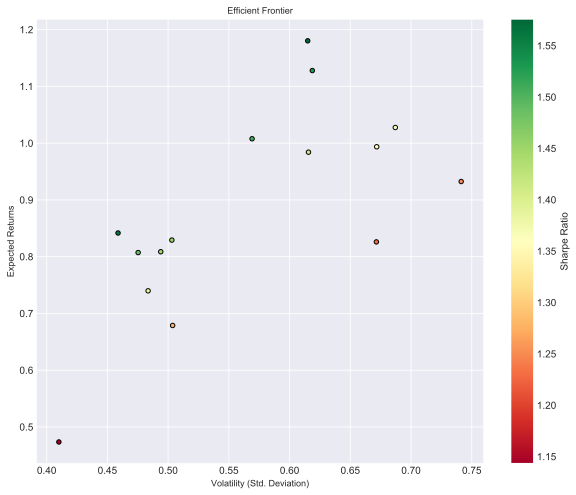

In [25]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
#fig, ax = plt.subplots()
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', 
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)', fontsize = 9)
plt.ylabel('Expected Returns', fontsize = 9)
plt.title('Efficient Frontier', fontsize = 9)
plt.show()

# Оптимальное соотношение активов

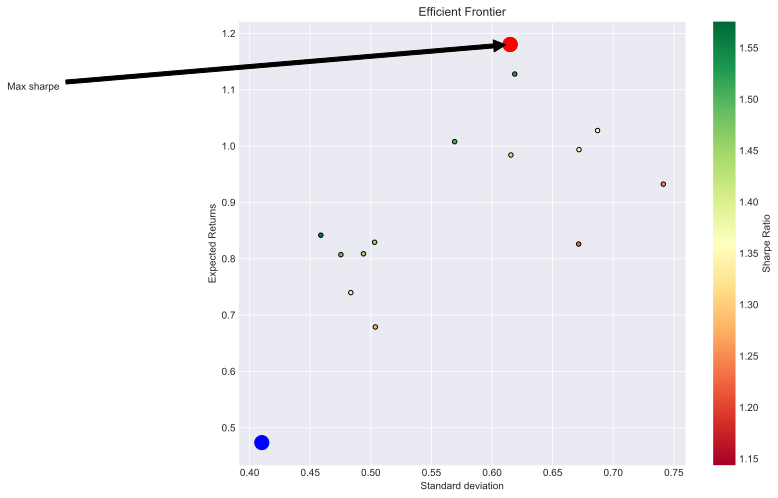

In [26]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
max_returns = df['Returns'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]
max_return_portfolio = df.loc[df['Returns'] == max_returns]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='green', marker='o', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='o', s=200 )
plt.scatter(x=max_return_portfolio['Volatility'], y=max_return_portfolio['Returns'], c='red', marker='o', s=200 )

plt.annotate('Max sharpe', xy=(sharpe_portfolio['Volatility'], sharpe_portfolio['Returns']), xytext=(0.2, 1.1), 
             arrowprops=dict(facecolor='black', shrink=0.01))

plt.xlabel('Standard deviation')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [27]:
good_sharpe_portfolios = df.loc[df['Sharpe Ratio'] > 1.8]
good_sharpe_portfolios = good_sharpe_portfolios.loc[good_sharpe_portfolios['Returns'] > 1.028]
good_sharpe_portfolios = good_sharpe_portfolios.loc[good_sharpe_portfolios['Volatility'] < 0.7411]
good_sharpe_portfolios = good_sharpe_portfolios.loc[good_sharpe_portfolios['BTC Weight'] > 0.4]
good_sharpe_portfolios['Cash'] = 1 - good_sharpe_portfolios['BTC Weight'] - good_sharpe_portfolios['ETH Weight'] - good_sharpe_portfolios['LTC Weight']
good_sharpe_portfolios

,Returns,Volatility,Sharpe Ratio,BTC Weight,ETH Weight,LTC Weight,Cash


In [19]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
#fig, ax = plt.subplots()
good_sharpe_portfolios.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', 
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)', fontsize = 9)
plt.ylabel('Expected Returns', fontsize = 9)
plt.title('Efficient Frontier', fontsize = 9)
plt.show()

ValueError: scatter requires x column to be numeric

In [20]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)
print(max_return_portfolio.T)

                   983
Returns       0.326432
Volatility    0.160726
Sharpe Ratio  1.838245
BTC Weight    0.045392
ETH Weight    0.094400
LTC Weight    0.030952
                  1315
Returns       1.787022
Volatility    0.621015
Sharpe Ratio  1.959192
BTC Weight    0.362728
ETH Weight    0.313084
LTC Weight    0.071957
                   725
Returns       3.075159
Volatility    1.113491
Sharpe Ratio  1.793973
BTC Weight    0.163948
ETH Weight    0.696305
LTC Weight    0.139141
